# House Prices - Advaced Regression Techniuqes

To predict sales prices and practice feature engineering, RFs, and gradient boosting.


Theeraphan - 
June 2022

This notebook is very important to me as it helped me to begin my journey on Kaggle, And understanding statistical.

This project, I've read some great notebooks here:

1. [Comprehensive data exploration with Python](https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python/notebook)
2. [A study on Regression applied to the Ames dataset](https://www.kaggle.com/code/juliencs/a-study-on-regression-applied-to-the-ames-dataset/notebook)
3. [Regularized Linear Models](https://www.kaggle.com/code/apapiu/regularized-linear-models/notebook)
4. [XGBoost + Lasso](https://www.kaggle.com/code/humananalog/xgboost-lasso/script)
5. [Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard/notebook)

Woo!, I just learn a lot.

Let's start coding.

In [3]:
# invite people to the party
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# for ignore warnings
import warnings
def ignore_warn(*arg, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

# for statistics
from scipy import stats
from scipy.stats import norm, skew 

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # limit float output to 3 decimal points

In [84]:
# let's import the train test dataset into pandas dataframe
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [85]:
# Check the first five rows of the train dataset
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [86]:
# Check the first five rows of the test dataset
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [87]:
# Check the number of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)


In [88]:
# Save 'Id' column for dropping
train_ID = train['Id']
test_ID = test['Id']

# Dropping the 'Id' column since it's unnecessary for features
train.drop('Id', axis=1 , inplace=True)
test.drop('Id', axis=1, inplace=True)

# check the number of sample and features after dropping Id column
print("The train data size after dropping Id feature is : {}".format(train.shape))
print("The test data size after dropping Id feature is : {}".format(test.shape))

The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79)


# Understand the problem.

We'll look at each variable and do an analysis about their meaning and importance for this problem.

Despite the strange names I gave to the chapters:
    
* Understand the problem. We'll look at each variable and do a philosophical analysis about their meaning and importance for this problem.
* Univariable study. We'll just focus on the dependent variable ('SalePrice') and try to know a little bit more about it.
* Multivariate study. We'll try to understand how the dependent variable and independent variables relate.
* Basic cleaning. We'll clean the dataset and handle the missing data, outliers and categorical variables.
* Test assumptions. We'll check if our data meets the assumptions required by most multivariate techniques.

### 1. What can we expect ?

In order to understand our data, we can look at each variable and try to understand thir meaning and relevance to this problem.

(This is important for me)
In order to have some discipline in our analysis, we can create an excel spreadsheet with the following columns:

* **Variable** - Variable name.
* **Type** - Identification of the variables type.There are two possible values for this field: 'numerical' or 'categorical'. By 'numerical' we mean variables for which the values are numbers, and by 'categorical' we mean variables for which the values are categories.
* **Segment** - dentification of the variables' segment. We can define three possible segments: building, space or location. When we say 'building', we mean a variable that relates to the physical characteristics of the building (e.g. 'OverallQual'). When we say 'space', we mean a variable that reports space properties of the house (e.g. 'TotalBsmtSF'). Finally, when we say a 'location', we mean a variable that gives information about the place where the house is located (e.g. 'Neighborhood').
* **Expectation** - Our expectation about the variable influence in 'SalePrice'. We can use a categorical scale with 'High', 'Medium' and 'Low' as possible values.
* **Conclusion** - Our conclusions about the importance of the variable, after we give a quick look at the data. We can keep with the same categorical scale as in 'Expectation'.
* **Comments** - Any general comments that occured to us.

While 'Type' and 'Segment' is just for possible future reference, the column 'Expectation' is important because it will help us develop a 'sixth sense'. To fill this column, we should read the description of all the variables and, one by one, ask ourselves:

more detail : https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data


### 2. Analyzing 'SalePrice'

'SalePrice' is the reason of our quest, Yes this is Target of the quest. we want to know some about describe() of 'SalePrice' have? 

In [89]:
# descriptive statistics summary
train['SalePrice'].describe()

count     1460.000
mean    180921.196
std      79442.503
min      34900.000
25%     129975.000
50%     163000.000
75%     214000.000
max     755000.000
Name: SalePrice, dtype: float64

Well, It seems that minimum price is larger than zero. Excellent!

We're want to know more detail of 'SalePrice'

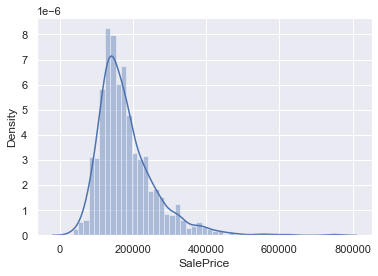

In [90]:
#histogram
sns.distplot(train['SalePrice']);

This histogram shows 
* Deviate from the normal distribution.
* Have appreciable positive skeness.
* Show peakedness.

In [91]:
# let's check measure of skewness and kurtosis
print('Skewness: %f' % train['SalePrice'].skew())
print('Kurtosis: %f' % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


**Relationship with numerical variables**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


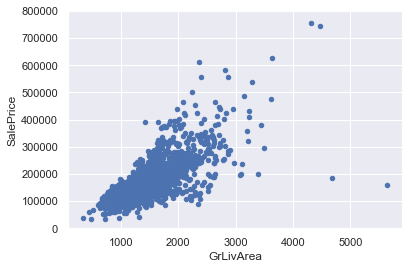

In [92]:
# let's check relationship of GrLivArea/SalePrice by scatter plot
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

It seems that 'SalePrice' and 'GrLiveArea' are really have really friends, with a linear relationship.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


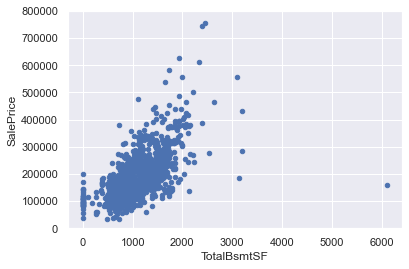

In [93]:
# let's check relationship of TotalBsmtSF/SalePrice by scatter plot 
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

'TotalBsmtSF' look like great friend of 'SalePrice' !

**Relationship with categorical features**

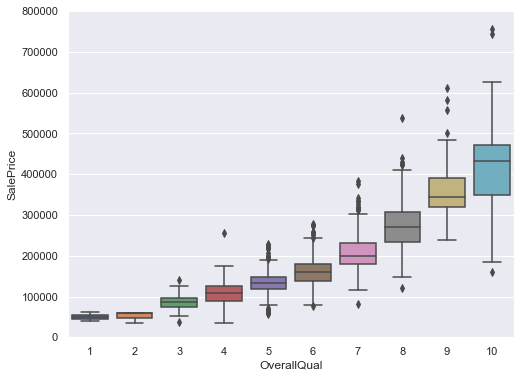

In [94]:
# let's create a box plot of OverallQual/SalePrice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
fig, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000);

'OverallQual' Look seems old friend relationship with 'SalePrice'!

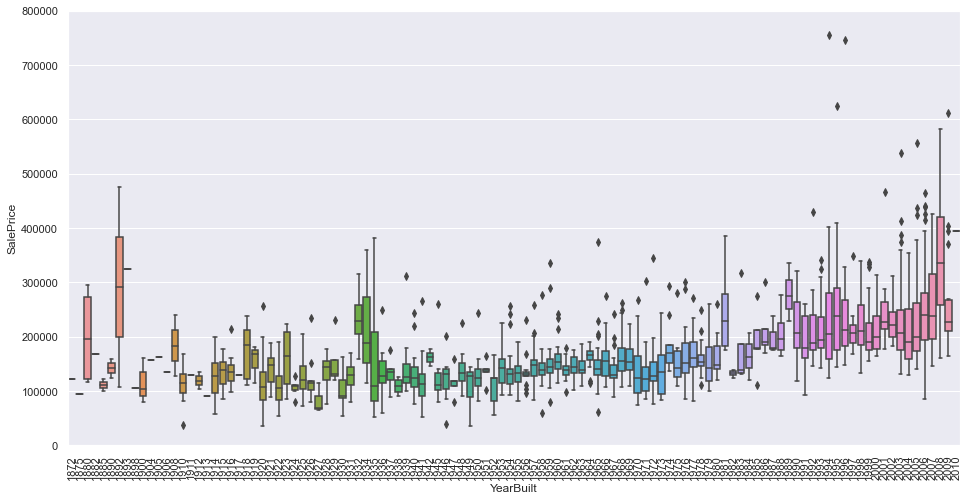

In [95]:
# Let's check relationship between YearBuilt and SalePrice.
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
fig, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y='SalePrice', data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

Look like 'SalePrice' is more prone to spend more money in new stuff that in old relics.

In summary

* 'GrLivArea' and 'TotalBsmtSF' seem to be linerly related with 'SalePrice'.
* 'OverallQuall' and 'YearBuilt' also seem to be related with 'SalePrice'.

### 3. DeepDive in 'SalePrice'

We're followed our intuition and analyzed the variables we thought were important. In spite of our efforts to give an objective character to our analysis, we must say that our starting point was subjective...

Let's do more objective analysis.

To explore this, we'll start with some practical:
* Correlation matrix (heatmap style).
* 'SalePrice' correlation matrix (zoomed heatmap style).
* Scatter plots between the most correlated variables.

**Correlation matrix (heatmap style)**

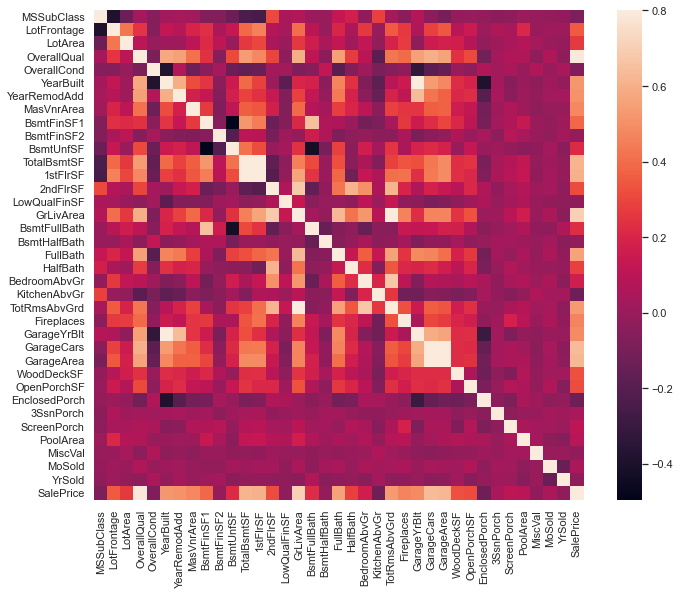

In [66]:
#Let's plot the Correlation matrix
corrmatrix = train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmatrix, vmax=0.8, square=True);

First sight, there are two red colored squares that get my attention. the first one refers to the 'TotalBsmtSF' and '1stFlrSF' varibles,
and the second one refers to the 'GarageX'

**Note:** This heatmap is the best way to get quick overview of our reletionships.

Another thing that got my attention was the 'SalePrice' correlations. We can see our we'll known 'GrLivArea', 'TotalBsmtSF', and 'OverallQual'.

**'SalePrice' correlation matrix (zoomed heatmap style)**

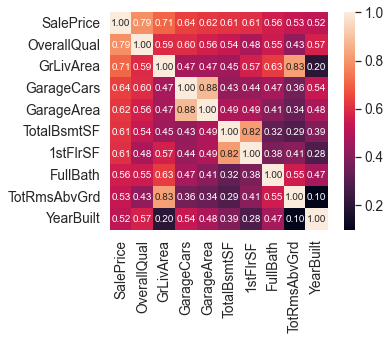

In [67]:
# Let's plot the 'SalePrice' correlation matrix zoomed heat map.
k = 10 # this is number of variable for heatmap
cols = corrmatrix.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

These are the variables most correlated with 'SalePrice':
   * 'OverallQual','GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'.
   * 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables.
   * 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers.
   * 'Fullbath'
   * 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again.
   * 'YearBuilt' It seems that 'YearBuilt' is slightly correlated with 'SalePrice'.

**Let's proceed to the scatter plots**

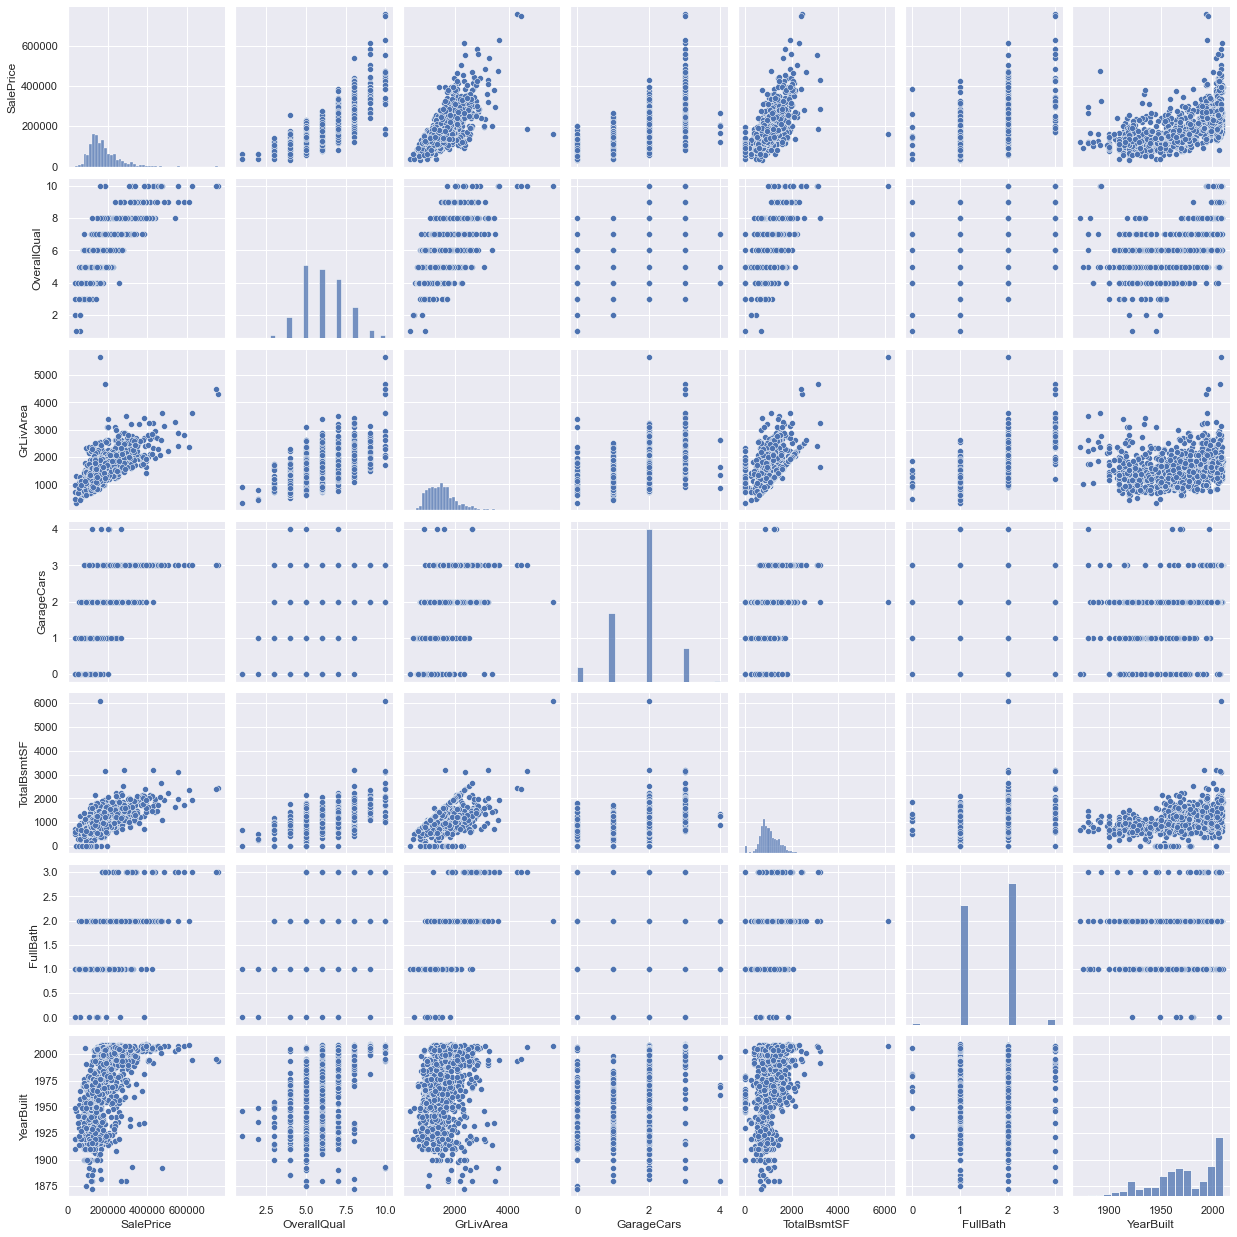

In [68]:
#scatteplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

Although we already know some of the main figures, this mega scatter plot gives us a reasonable idea about variables relationships.

One of the figures we may find interesting is the one between `'TotalBsmtSF'` and `'GrLivArea'`. In this figure we can see the dots drawing a linear line, which almost acts like a border. It totally makes sense that the majority of the dots stay below that line. 
Basement areas can be equal to the above ground living area, but it is not expected a basement area bigger than the above ground living area.

The plot concerning `'SalePrice'` and `'YearBuilt'` can also make us think. In the bottom of the `'dots cloud'`,we see what almost appears to be a shy exponential function (be creative). We can also see this same tendency in the upper limit of the 'dots cloud' (be even more creative). Also, notice how the set of dots regarding the last years tend to stay above this limit (that the prices are increasing faster now).


### 4. Outliers

Outliers is also something that we should be aware of. Why? Because outliers can markedly affect our models and can be a valuable source of information, providing us insights about specific behaviours.

Outliers is a complex subject and it deserves more attention. Here, we'll just do a quick analysis through the standard deviation of 'SalePrice' and a set of scatter plots.


Let's explore these outliers

**Univariate analysis**

The primary concern here is to establish a threshold that defines an observation as an outlier. To do so, we'll standardize the data. In this context, data standardization means converting data values to have mean of 0 and a standard deviation of 1.

In [96]:
#Standardizing data
from sklearn.preprocessing import StandardScaler
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

outer range (high) of the distribution:
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


How 'SalePrice' looks:
* Low range values are similar and not too far from 0
* high range values are far from 0 and the 7.somthing values are really out of range.

For now, we'll consider any of these values as an outlier but we should be careful with those two 7.somthings values

**Bivariate analysis**

We already know the following scatter plots by heart. However, when we look to things from a new perspective, there's always something to discover.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


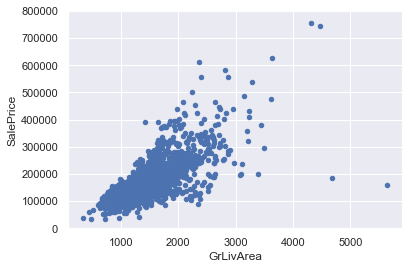

In [97]:
# let's plot the scatter plot of GrLivArea/SalePrice again.
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

What has been revealed:

* The two values with bigger 'GrLivArea' seem strange and they are not following the crowd. We can speculate why this is happening. Maybe they refer to agricultural area and that could explain the low price. I'm not sure about this but I'm quite confident that these two points are not representative of the typical case. Therefore, we'll define them as outliers and delete them.
* The two observations in the top of the plot are those 7.something observations that we said we should be careful about. They look like two special cases, however they seem to be following the trend. For that reason, we will keep them.

In [102]:
#Deleting outliers point
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice']<300000)].index)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


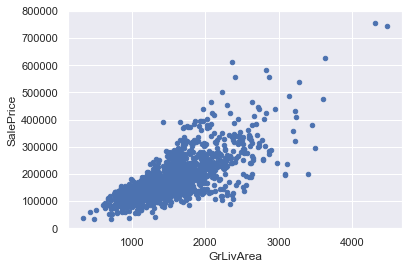

In [103]:
# check the graph again
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0, 800000));

**Note:** Outliers removel is note always safe. We decided to delete these two as they are very huge and really bad (extremely large areas for very low price)

**Target Varibles In the search for normality**

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

* **Histogram** - Kurtosis and skewness.
* **Normal probability plot** - Data distribution should closely follow the diagonal that represents the normal distribution.

'SalePrice' is the varible we need to predict. So let's do some analysis on this variable first.


 mu = 180932.92 and sigma = 79467.79



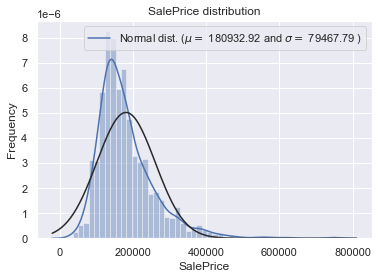

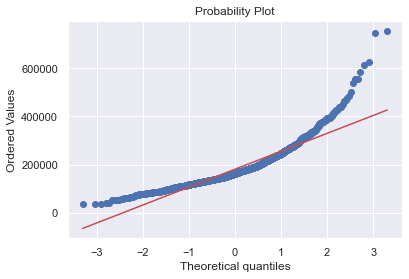

In [108]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The target variable is right skewed. As (linear) models love normally distributed data , we need to transform this variable and make it more normally distributed.

**Log-transformation of the target variable**

In [109]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])


 mu = 12.02 and sigma = 0.40



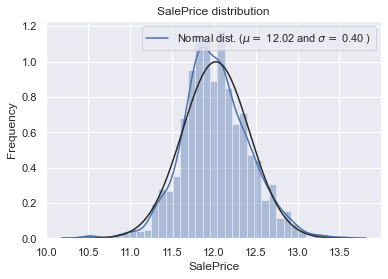

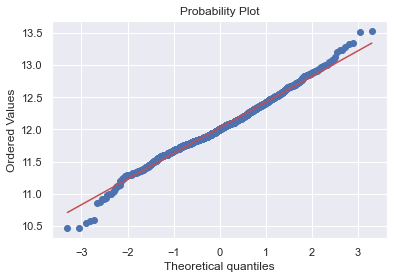

In [110]:
#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

The skew seems now corrected and the data appears more normally distributed.

**Features engineering**

let's first concatenate the train and test data in the same dataframe.

In [112]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train['SalePrice'].values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


### 4. Missing data

Important question when thinking about missing data:
* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

In [117]:
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageYrBlt,5.451
GarageQual,5.451
GarageCond,5.451


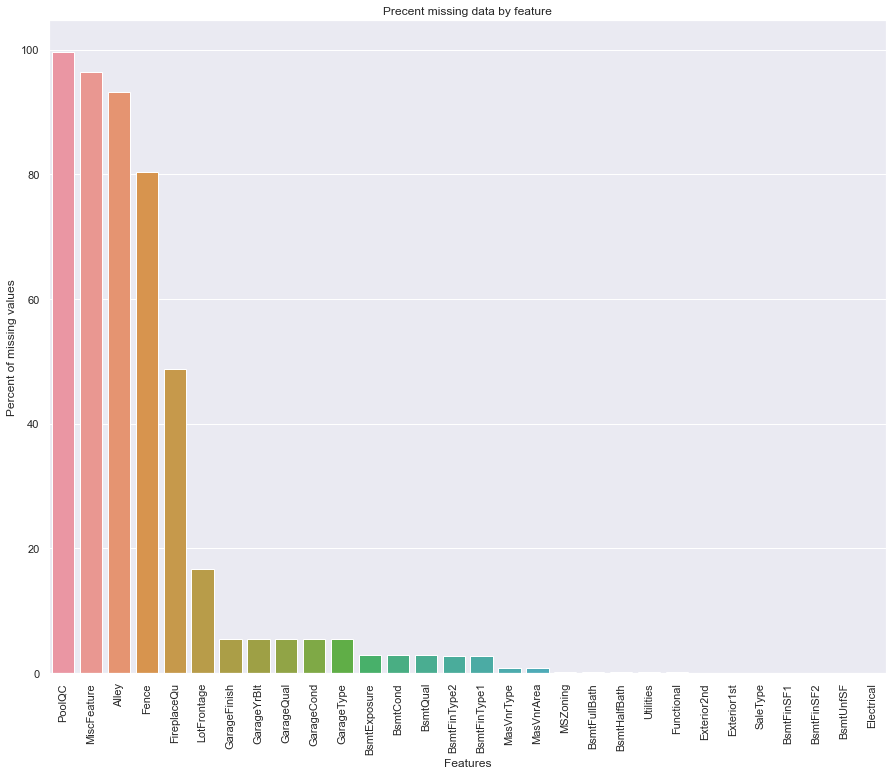

In [119]:
# let's plot the graph to checking more visualize.
fig, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features')
plt.ylabel('Percent of missing values')
plt.title('Precent missing data by feature');

**Imputing missing values**

We impute them by proceeding sequentially through features with missing values

* PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.

In [120]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

* MiscFeature : data description says NA means "no misc feature"

In [121]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

* Alley : data description says NA means "no alley access"

In [122]:
all_data["Alley"] = all_data["Alley"].fillna("None")

* Fence : data description says NA means "no fence"

In [123]:
all_data["Fence"] = all_data["Fence"].fillna("None")

* FireplaceQu : data description says NA means "no fireplace"

In [124]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

* LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.

In [125]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

* GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None

In [126]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

* GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)

In [127]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

* BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement

In [128]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

* BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.

In [129]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

* MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.

In [130]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'

In [132]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

In [133]:
all_data = all_data.drop(['Utilities'], axis=1)

* Functional : data description says NA means typical

In [134]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.

In [135]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

* KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

In [136]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

* Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [137]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

* SaleType : Fill in again with most frequent which is "WD"

In [138]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

* MSSubClass : Na most likely means No building class. We can replace missing values with None

In [139]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

Is there any remaining missing value ?

In [140]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


It remains no missing value.

### More features engeneering

**Transforming some numerical variables that are really categorical**

In [142]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**Label Encoding some categorical variables that may contain information in their ordering set**

In [143]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# check shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


**Adding one more important feature**

Since area related features are very important to determine house prices, we add one more feature which is the total area of basement, first and second floor areas of each house

In [144]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Skewed features**

In [146]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


**Box Cox Transformation of (highly) skewed features**

We use the scipy function boxcox1p which computes the Box-Cox transformation of  1+x .

Note that setting  λ=0  is equivalent to log1p used above for the target variable.

See this page for more details : https://onlinestatbook.com/2/transformations/box-cox.html

Box Cox Transformation as well as the scipy function's page : https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.special.boxcox1p.html

In [147]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


**Getting dummy categorical features**

In [148]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


Getting the new train and test sets.

In [149]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [151]:
#check shape
train.shape, test.shape

((1458, 220), (1459, 220))

# Modelling

**Import librairies**

In [157]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

**Note:**
* ElasticNet - Linear regression with combined L1 and L2 priors as regularizer.
* Lasso - Linear Model trained with L1 prior as regularizer (aka the Lasso).
* BayesianRidge - Bayesian ridge regression.
* LassoLarsIC - Lasso model fit with Lars using BIC or AIC for model selection.
* RandomForestRegressor - A random forest regressor.
* GradientBoostingRegressor - Gradient Boosting for regression.
* KernelRidge - Kernel ridge regression.
* make_pipeline - Construct a Pipeline from the given estimators.
* RobustScaler - Scale features using statistics that are robust to outliers.
* BaseEstimator - Base class for all estimators in scikit-learn.
* TransformerMixin - Mixin class for all transformers in scikit-learn.
* RegressorMixin - Mixin class for all regression estimators in scikit-learn.
* clone - Construct a new unfitted estimator with the same parameters.
* KFold - K-Folds cross-validator Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
* cross_val_score - Evaluate a score by cross-validation.
* train_test_split - Split arrays or matrices into random train and test subsets.
* mean_squared_error - Mean squared error regression loss.
* xgboost - A Scalable Tree Boosting System.Tree boosting is a highly effective and widely used machine learning method
* lightgbm - LightGBM is a gradient boosting framework that uses tree based learning algorithms.

**Define a cross validation strategy**

We use the cross_val_score function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [158]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### Base Model

* LASSO Regression :
This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's Robustscaler() method on pipeline

In [159]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

* Elastic Net Regression :
again made robust to outliers

In [160]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

* Kernel Ridge Regression :

In [161]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting Regression :
With huber loss that makes it robust to outliers

In [162]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* XGBoost :

In [163]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM :

In [164]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

**Base models scores**

Let's see how these base models perform on the data by evaluating the cross-validation rmsle error

In [165]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [166]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [167]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [168]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [169]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[01:30:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:30:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false

In [170]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

### Stacking models

**Simplest Stacking approach : Averaging base models**

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance): https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [174]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

**Averaged base models score**

We just average four models here **ENet, GBoost, KRR and lasso**. Of course we could easily add more models in the mix.

In [175]:
#call functions
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



It seems even the simplest stacking approach really improve the score . This encourages us to go further and explore a less simple stacking approch.

**Less simple Stacking : Adding a Meta-model**

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

1. Split the total training set into two disjoint sets (here **train** and .**holdout** )

2. Train several base models on the first part (**train**)

3. Test these base models on the second part (**holdout**)

4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called **meta-model**.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as **meta-features** on which, the final prediction is done with the meta-model.

Explain here: http://i.imgur.com/QBuDOjs.jpg

 the base models are algorithms 0, 1, 2 and the meta-model is algorithm 3. The entire training dataset is A+B (target variable y known) that we can split into train part (A) and holdout part (B). And the test dataset is C.

B1 (which is the prediction from the holdout part) is the new feature used to train the meta-model 3 and C1 (which is the prediction from the test dataset) is the meta-feature on which the final prediction is done.

**Stacking averaged Models Class**

In [176]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

**Stacking Averaged models Score**

To make the two approaches comparable (by using the same number of models) , we just average **Enet KRR and Gboost**, then we add **lasso as meta-model**.

In [177]:
#call functions
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


We get again a better score by adding a meta learner

### Ensembling StackedRegressor, XGBoost and LightGBM

We add XGBoost and LightGBM to the StackedRegressor defined previously.

We first define a rmsle evaluation function.

In [179]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

**Final Training and Prediction**

**StackedRegressor:**

In [181]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665448


**XGBoost:**

In [182]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

[01:47:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.07876050033097799


**LightGBM:**

In [183]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
0.07169383068991829


In [184]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07542469074310124


**Ensemble prediction:**

In [185]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

**Submission**

In [186]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)